In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("/kaggle/input/animal-10-pytorch/dataset/train/")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("/kaggle/input/animal-10-pytorch/dataset/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("/kaggle/input/animal-10-pytorch/dataset/val/")

# PRETRAINED_MODEL = "/kaggle/input/modele2/e2.pth"

print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

16771 2094 2094 ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


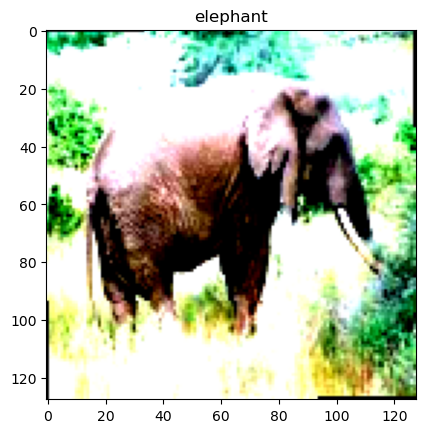

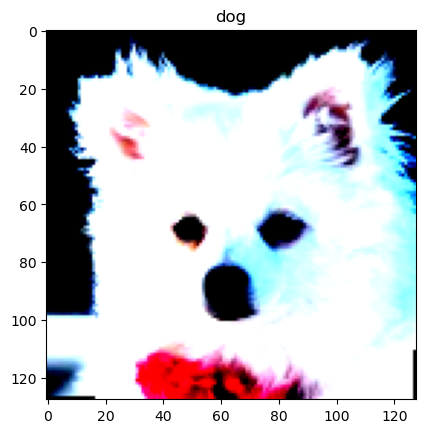

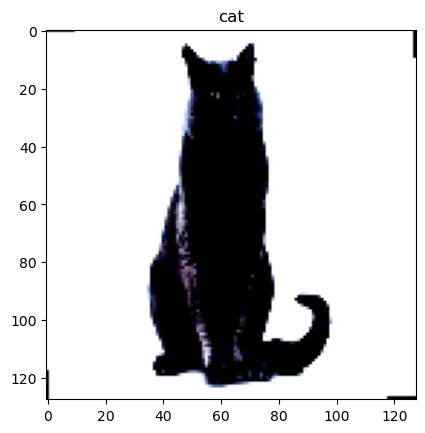

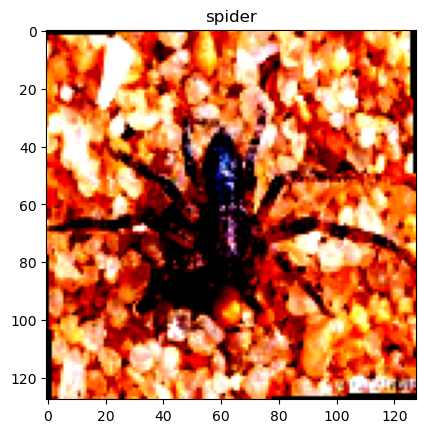

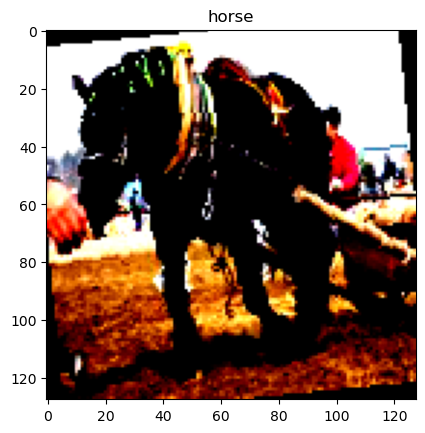

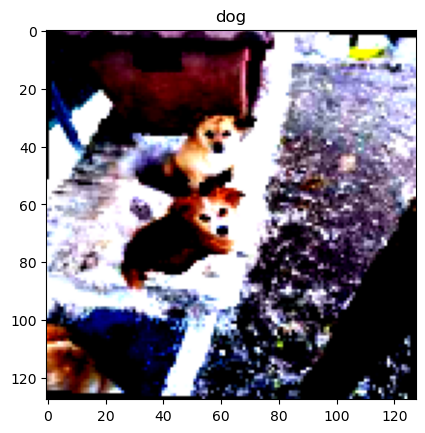

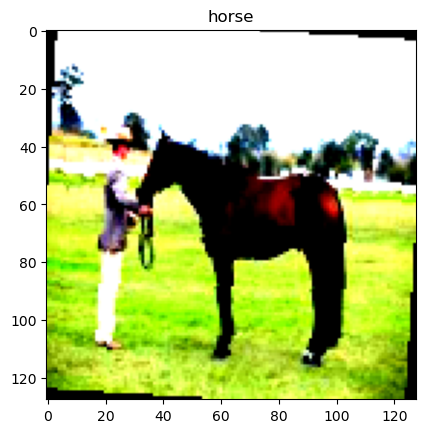

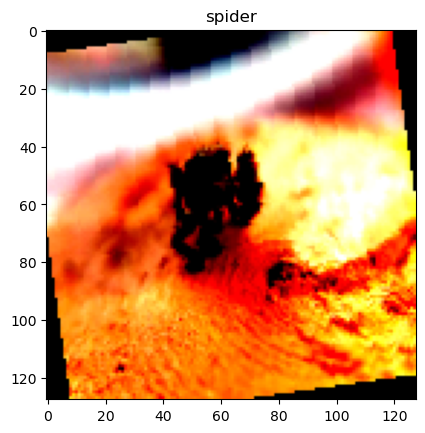

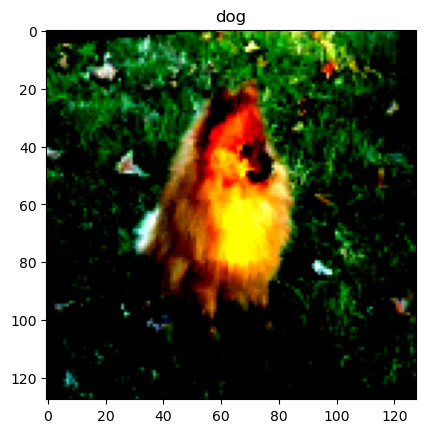

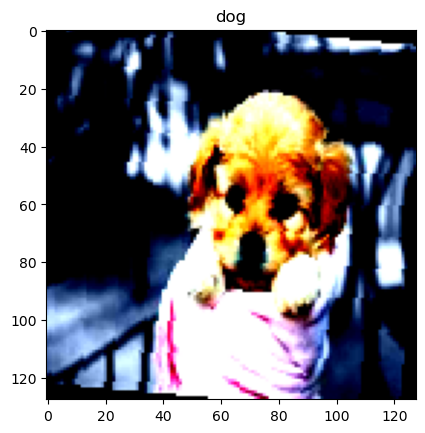

8


In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [4]:
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(512,8)
model = model.to(device)
# model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
    except:
        pass
torch.save(model.state_dict(), f"/kaggle/working/_e{epoch}.pth")

Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

1 0.000321565312333405 0.3154850635024745 0.012838616967201233 0.31852913085004775


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

2 0.0006558513268828392 0.38775266829646415 0.01124592125415802 0.4665711556829035


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

3 0.00033005228033289313 0.4909665494007513 0.008479177951812744 0.5491881566380133


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

4 0.0004260941641405225 0.5629360205115974 0.010500182397663593 0.6031518624641834


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

5 0.00018160972103942186 0.6081330868761553 0.009290417656302452 0.6212989493791786


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

6 0.000529724929947406 0.6448631566394372 0.004259967245161533 0.6580706781279847


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

7 0.00019295640231575817 0.679983304513744 0.011848663911223412 0.673352435530086


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

8 0.00018635016749612987 0.7069345894699183 0.005936816800385714 0.6986628462273161


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

9 0.00028838860453106463 0.7309641643312862 0.004661165177822113 0.7148997134670487


Train:   0%|          | 0/1049 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

10 0.00017397303599864244 0.7579154492874605 0.004724804777652025 0.6829035339063992


In [7]:
y_pred = []
y_true = []

test_loader2 = DataLoader(test_set, shuffle=True)
for images, labels in test_loader2:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output])
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels])

from sklearn.metrics import accuracy_score, classification_report


print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")
print(classification_report(y_true, y_pred,target_names=train_set.classes))

Overall Accuracy:  68.29  %
              precision    recall  f1-score   support

         cat       0.51      0.66      0.58       166
         cow       0.73      0.43      0.54       186
         dog       0.78      0.60      0.68       486
    elephant       0.40      0.89      0.55       144
       horse       0.74      0.67      0.70       262
       sheep       0.54      0.65      0.59       182
      spider       0.95      0.83      0.89       482
    squirrel       0.63      0.68      0.65       186

    accuracy                           0.68      2094
   macro avg       0.66      0.68      0.65      2094
weighted avg       0.73      0.68      0.69      2094

